In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
from shapely.geometry import mapping

# Historical Heatwaves Incidence and change in maximum temperature

In this notebook, we will explore heatwaves incidence, based on [pre-calculated data](ttps://worldbankgroup.sharepoint.com.mcas.ms/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=Yvwh8r&cid=fccdf23e%2D94d5%2D48bf%2Db75d%2D0af291138bde&FolderCTID=0x012000CFAB9FF0F938A64EBB297E7E16BDFCFD&id=%2Fteams%2FDevelopmentDataPartnershipCommunity%2DWBGroup%2FShared%20Documents%2FProjects%2FHeatwaves%20Data%20Collaborative%2FData%2Fremotesensing%2Fhwdi%5F5degC&viewid=80cdadb3%2D8bb3%2D47ae%2D8b18%2Dc1dd89c373c5) obtained from NASA's [GLDAS](https://ldas.gsfc.nasa.gov/gldas)

## Data

### GLDAS

In [3]:
# parallel ensures that it being parallel processing
#ds_mean3 = xr.open_mfdataset("../../data/gldas/ymean3/wld_cli_*.nc4", parallel=True)
ds_percentile390 = xr.open_mfdataset("../../data/gldas/ypercentile90/wld_cli_*.nc4", parallel = True)
# ds_mean4= xr.open_mfdataset("../../data/gldas/ymean4/wld_cli_*.nc4", parallel = True)
# ds_percentile490= xr.open_mfdataset("../../data/gldas/ypercentile490/wld_cli_*.nc4", parallel = True)
ds_mean2=xr.open_mfdataset("../../data/gldas/ymean2/wld_cli_*.nc4", parallel = True)
# ds_percentile290=xr.open_mfdataset("../../data/gldas/ypercentile290/wld_cli_*.nc4", parallel = True)

In [2]:
ds_tasmax = xr.open_mfdataset('../../data/gldas/tasmax/tasmax/wld_cli_*.nc4', parallel=True)

In [91]:
ds_2021 = xr.open_dataset(
    "../../data/gldas/ymean3/wld_cli_gldas21_tasmax_ydrunmean3_hwdi_2021.nc4"
)
# ds_2022 = xr.open_dataset("../../data/gldas/ymean3/wld_cli_gldas21_tasmax_ydrunmax3_hwdi_2022.nc4")

Exploring the data, 

In [12]:
time_bnds = [(np.datetime64("1948-01-01"), np.datetime64("2023-01-31"))]
time_var = ds_tasmax.variables["time"]
start_date = np.datetime64("2022-02-01")
end_date = np.datetime64("2022-04-30")

start_index = np.where(time_var[:] == start_date)[0]
end_index = np.where(time_var[:] == end_date)[0]

### Boundaries

In [5]:
INDIA = geopandas.read_file("../../data/shapefiles/india_district/sh819zz8121.shp").to_crs("EPSG:4326")
CHENNAI = INDIA[INDIA["laa"] == "CHENNAI"]

Taking a quick visual inspection,

In [95]:
CHENNAI.explore()

## Clipping

In this step, our intention is to clip the heatwaves incident data using boundaries.

In [13]:
ds_tasmax

<xarray.Dataset>
Dimensions:      (time: 27149, bnds: 2, lon: 1440, lat: 600)
Coordinates:
  * time         (time) datetime64[ns] 1948-01-01T13:30:00 ... 2022-04-30T13:...
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat          (lat) float32 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
    spatial_ref  int32 0
Dimensions without coordinates: bnds
Data variables:
    time_bnds    (time, bnds) datetime64[ns] dask.array<chunksize=(366, 2), meta=np.ndarray>
    Tasmax       (time, lat, lon) float32 dask.array<chunksize=(366, 600, 1440), meta=np.ndarray>
Attributes: (12/21)
    CDI:                    Climate Data Interface version 1.9.10 (https://mp...
    Conventions:            CF-1.6
    source:                 Noah_v3.6 forced with Princeton_V2.2
    institution:            NASA GSFC
    missing_value:          -9999.0
    tavg definision::       past 3-hour average
    ...                     ...
    DX:                     0.25
    DY:                     0.25
    history_L34RS:          'Created by L34RS v1.4.2 @ NASA GES DISC on Septe...
    frequency:              day
    history:                Sun Nov 13 12:06:30 2022: cdo -z zip_5 -setattrib...
    CDO:                    Climate Data Operators version 1.9.10 (https://mp...

In [18]:
import shapely
CHENNAI['geometry'] = CHENNAI['geometry'].apply(lambda x: shapely.wkb.loads(
        shapely.wkb.dumps(x, output_dimension=2)))

c:\Users\sahit\anaconda3\envs\heatwaves\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [21]:
ds_mean2

<xarray.Dataset>
Dimensions:                                                (time: 75,
                                                            lon: 1440, lat: 600)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
  * lon                                                    (lon) float32 -179...
  * lat                                                    (lat) float32 -59....
    spatial_ref                                            int32 0
Data variables:
    heat_wave_duration_index_wrt_mean_of_reference_period  (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    heat_waves_per_time_period                             (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Dec 08 04:41:45 2022: cdo -z zip_5 eca_hwdi,2,5 wld_cli...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [19]:
clipped_chennai = ds_tasmax.rio.clip(CHENNAI.geometry.values,drop=False)

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: time_bnds

In [7]:
# ds_mean3.rio.write_crs("EPSG:4326", inplace=True)
# clipped_chennai = ds_mean3.rio.clip(CHENNAI.geometry.values, CHENNAI.crs, drop=False)
# clipped_india = ds_mean3.rio.clip(INDIA.geometry.values, INDIA.crs, drop=False)


ds_mean2.rio.write_crs("EPSG:4326", inplace=True)
ds_tasmax.rio.write_crs("EPSG:4326", inplace=True)
ds_percentile390.rio.write_crs('EPSG:4326', inplace=True)

clipped_chennai = ds_tasmax.rio.clip(CHENNAI.geometry.values,all_touched=True, drop=True)
clipped_india = ds_tasmax.rio.clip(INDIA.geometry.values, all_touched=True, drop=True)

MissingSpatialDimensionError: x dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'x' can address this. Data variable: time_bnds

Now, converting to a dataframe and `geopandas.GeoDataFrame`

In [33]:
df = clipped_chennai.to_dataframe().reset_index()

gdf = geopandas.GeoDataFrame(
    df.reset_index(), geometry=geopandas.points_from_xy(df["lon"], df["lat"])
)

In [23]:
df = clipped_chennai.to_dataframe().reset_index()
df[df['time'].dt.year==2016]

,time,lon,lat,spatial_ref,heat_wave_duration_index_wrt_mean_of_reference_period,heat_waves_per_time_period
272,2016-12-31 13:30:00,80.125,12.875,0,0.0,0.0
273,2016-12-31 13:30:00,80.125,13.125,0,7.0,2.0
274,2016-12-31 13:30:00,80.375,12.875,0,NaN,NaN
275,2016-12-31 13:30:00,80.375,13.125,0,NaN,NaN


In [28]:
df['heat_waves_per_time_period'] = df['heat_waves_per_time_period'].fillna(0)
df['heat_waves_per_time_period'] = df['heat_waves_per_time_period'].astype(int)

In [12]:
gdf = gdf.set_crs('epsg:4326')

<Axes: >

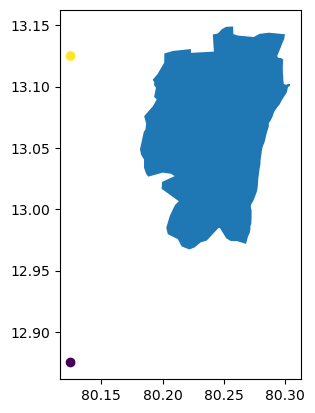

In [38]:
fig, ax = plt.subplots()
CHENNAI.plot(ax=ax)
gdf[gdf['time'].dt.year==2016].plot(column = 'heat_waves_per_time_period', ax=ax)

<Axes: >

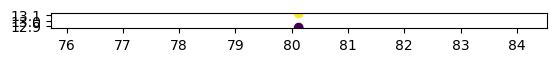

<Axes: xlabel='time'>

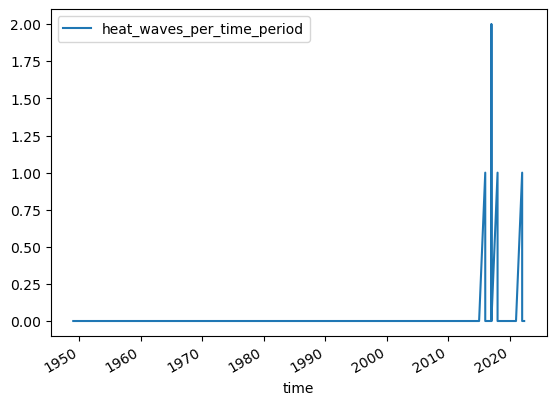

In [29]:
df.plot(x='time', y='heat_waves_per_time_period')

## 

Text(0, 0.5, '# of heatwaves')

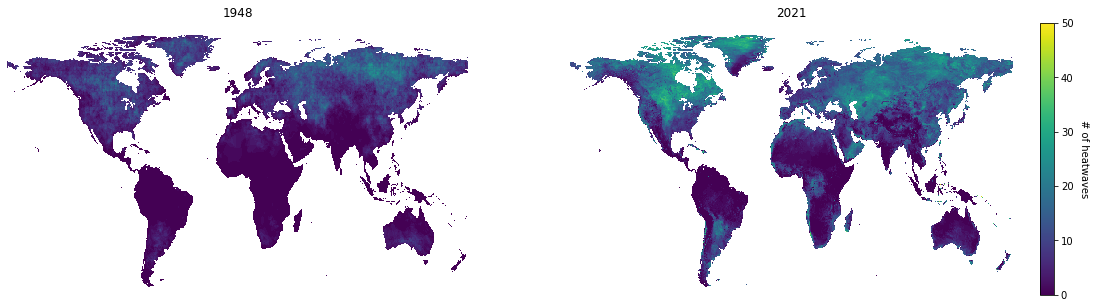

In [242]:
fig, ax = plt.subplots(
    1,
    2,
    sharex=True,
    sharey=True,
    figsize=(20, 5),
    gridspec_kw={"width_ratios": [1, 1.2]},
)

im = ds_1948["heat_waves_per_time_period"].plot(ax=ax[0], vmin=0, vmax=50)
im2 = ds_2021["heat_waves_per_time_period"].plot(ax=ax[1], vmin=0, vmax=50)
# cbar_ax = fig.add_axes([0, 10, 20, 40])
# fig.colorbar(im, cax=cbar_ax)
# ax.axis('off')

ax[0].set_title("1948")
ax[1].set_title("2021")

# ax[0].get_legend().remove()

for i in [0, 1]:
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].axis("off")

handles, labels = ax[1].get_legend_handles_labels()
# print(labels)

cb = im.colorbar
cb.remove()

cb = im2.colorbar
cb.ax.get_yaxis().labelpad = 15
cb.ax.set_ylabel("# of heatwaves", rotation=270)

In [33]:
df_mean3 = ds_mean3.to_dataframe().groupby(["time", "lat", "lon"]).sum()
df1_mean3 = df_mean3.groupby("time").sum()

In [166]:
df_percentile390 = ds_percentile390.to_dataframe().groupby(["time"]).sum()
df_percentile490 = ds_percentile490.to_dataframe().groupby(["time"]).sum()
df_percentile290 = ds_percentile290.to_dataframe().groupby(["time"]).sum()

df_mean2 = ds_mean2.to_dataframe().groupby(["time"]).sum()

In [169]:
df_mean4 = ds_mean4.to_dataframe().groupby(["time"]).sum()

In [120]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from matplotlib.collections import PatchCollection
# from matplotlib.colors import ListedColormap
# import pandas as pd

In [38]:
import matplotlib.pyplot as plt
from matploltib import ListedColormap

cmap = ListedColormap(
    [
        "#08306b",
        "#08519c",
        "#2171b5",
        "#4292c6",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#deebf7",
        "#fee0d2",
        "#fcbba1",
        "#fc9272",
        "#fb6a4a",
        "#ef3b2c",
        "#cb181d",
        "#a50f15",
        "#67000d",
    ]
)

ModuleNotFoundError: No module named 'matploltib'

Text(0.5, 1.0, 'Number of heatwaves using different definitions of a heatwave')

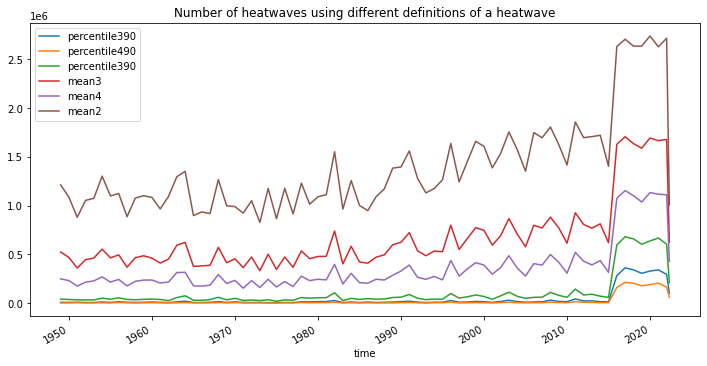

In [177]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 6))
df_percentile390[["heat_waves_per_time_period"]].plot(ax=ax, label="percentile390")
df_percentile490[["heat_waves_per_time_period"]].plot(ax=ax)
df_percentile290[["heat_waves_per_time_period"]].plot(ax=ax)

df_mean3[["heat_waves_per_time_period"]].plot(ax=ax)
df_mean4[["heat_waves_per_time_period"]].plot(ax=ax)
df_mean2[["heat_waves_per_time_period"]].plot(ax=ax)

plt.legend(
    ("percentile390", "percentile490", "percentile390", "mean3", "mean4", "mean2"),
    loc="upper left",
)
plt.title("Number of heatwaves using different definitions of a heatwave")

In [246]:
df_percentile290.rename(
    columns={"heat_waves_per_time_period": "heat_waves_per_time_period_p290"},
    inplace=True,
)
df_percentile390.rename(
    columns={"heat_waves_per_time_period": "heat_waves_per_time_period_p390"},
    inplace=True,
)
df_percentile490.rename(
    columns={"heat_waves_per_time_period": "heat_waves_per_time_period_p490"},
    inplace=True,
)

df_mean2.rename(
    columns={"heat_waves_per_time_period": "heat_waves_per_time_period_m2"},
    inplace=True,
)
df_mean3.rename(
    columns={"heat_waves_per_time_period": "heat_waves_per_time_period_m3"},
    inplace=True,
)
df_mean4.rename(
    columns={"heat_waves_per_time_period": "heat_waves_per_time_period_m4"},
    inplace=True,
)

In [251]:
# df_mean4.merge(df_mean3, on = 'time')

In [254]:
df_mean4.merge(df_mean3, on="time").merge(df_mean2, on="time").merge(
    df_percentile290, on="time"
).merge(df_percentile390, on="time").merge(df_percentile490, on="time").to_excel(
    "../data/heatwave_definitions.xlsx"
)

In [192]:
ds.sel(time=slice("2021-01-01", "2021-12-31")).plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

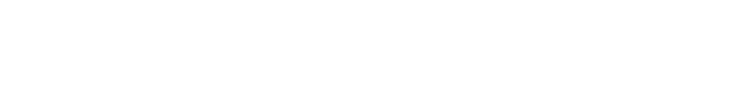

In [132]:
fig = plt.figure(figsize=(10, 1))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

# create a collection with a rectangle for each year

col = PatchCollection([Rectangle((y, 0), 1, 1) for y in range(1948, 2022 + 1)])

# reference = df1['heat_waves_per_time_period'].mean()
# heat_waves = df1['heat_waves_per_time_period'].dropna()

# col.set_array(heat_waves)
# col.set_cmap(cmap)
# col.set_clim(reference, reference)
# ax.add_collection(col)